# 05 — Frequency transfer with PML (SimpleFNO)

This notebook trains a neural network to map a Helmholtz solution at one
frequency to another frequency, using:

- the `HelmholtzFreqTransferDataset` that solves each sample with a PML shell,
- an FNO-style model (`SimpleFNO`),
- the generic `train_model` and `eval_relative_metrics` utilities.

All numerical setup (grid, PML, frequencies) is defined at the top.


In [2]:
# === Cel 1: setup project, imports en patch direct_solve ===

from pathlib import Path
import sys

# 1. Vind project-root (map waar src/__init__.py staat)
here = Path().resolve()
PROJECT_ROOT = None
for parent in [here, *here.parents]:
    if (parent / "src" / "__init__.py").exists():
        PROJECT_ROOT = parent
        break

if PROJECT_ROOT is None:
    raise RuntimeError("Could not find project root containing 'src/__init__.py'")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Using PROJECT_ROOT =", PROJECT_ROOT)

# 2. Import direct vanuit submodules (vermijdt extra __init__-magie)
from src.config import GridSpec, PMLConfig, DATA_DIR, RESULTS_DIR
from src.ml import (
    SimpleFNO,
    train_model,
    eval_relative_metrics,
    HelmholtzFreqTransferDataset,
)

# 3. Patch: zorg dat operators.solve_with_pml_shell een direct_solve ziet
import src.operators as _ops
from src.solvers import direct_solve as _direct_solve

_ops.direct_solve = _direct_solve
print("Patched src.operators.direct_solve")


Using PROJECT_ROOT = C:\Users\31624\Documents\MIT\Programming\FreqTransfer
Patched src.operators.direct_solve


## 1. Numerical configuration (grid, PML, frequencies)

We define:

- a 2D grid `GridSpec`,
- a PML configuration `PMLConfig` that matches our "good" choice from the PML tuning notebook,
- source and target frequencies: ω_src → ω_tgt,
- a mapping `omega_to_k(ω)` to convert frequency to wavenumber.


In [3]:
import numpy as np

# --- Grid configuration ---
# Adjust shape / lengths to match your PML tuning notebook
grid = GridSpec(
    dims=2,
    shape=(48, 48),
    lengths=(1.0, 1.0),
)
print("Grid:", grid, "| spacing =", grid.spacing)

# --- PML configuration ---
# Fill in the parameters you found to work well in your PML notebook.
# Example: shell of 16 cells, polynomial order 2, sigma_max 10.0
pml_cfg = PMLConfig(
    thickness=16,
    m=2,
    sigma_max=10.0,
)
print("PML config:", pml_cfg)

# --- Frequency configuration ---
# Map u(omega_src) -> u(omega_tgt)
omega_src = 20.0  # "low" frequency
omega_tgt = 40.0  # "high" frequency

# Relation between frequency and wavenumber k.
# If your physics uses k = omega / c with wave speed c, set that here.
def omega_to_k(omega: float) -> float:
    c = 1.0  # wave speed; adjust if needed
    return float(omega / c)

print(f"omega_src = {omega_src}, omega_tgt = {omega_tgt}")
print(f"k_src = {omega_to_k(omega_src)}, k_tgt = {omega_to_k(omega_tgt)}")


Grid: GridSpec(dims=2, shape=(48, 48), lengths=(1.0, 1.0)) | spacing = (0.02127659574468085, 0.02127659574468085)
PML config: PMLConfig(thickness=16, m=2, sigma_max=10.0)
omega_src = 20.0, omega_tgt = 40.0
k_src = 20.0, k_tgt = 40.0


## 2. Dataset: `HelmholtzFreqTransferDataset` with PML

We now build a dataset of pairs

\\[
(u_{\omega_{\text{src}}},\; u_{\omega_{\text{tgt}}})
\\]

for multiple random point-source realizations.

`HelmholtzFreqTransferDataset`:

- uses `RandomPointSource` for each seed,
- calls `solve_with_pml_shell` internally to solve the PDE on an extended grid with PML,
- returns tensors shaped `(2, Ny, Nx)` with `[Re, Im]` channels. 


In [4]:
# Number of samples we want
n_samples = 200

# Fix seeds for reproducibility
rng = np.random.default_rng(0)
seeds = list(rng.integers(0, 1_000_000, size=n_samples))

dataset = HelmholtzFreqTransferDataset(
    grid=grid,
    pml=pml_cfg,
    omega_src=omega_src,
    omega_tgt=omega_tgt,
    seeds=seeds,
    omega_to_k=omega_to_k,
)

print("Number of samples in dataset:", len(dataset))

# Inspect shapes of one sample
u_src, u_tgt = dataset[0]
print("u_src shape:", u_src.shape, "u_tgt shape:", u_tgt.shape)


Number of samples in dataset: 200
u_src shape: torch.Size([2, 48, 48]) u_tgt shape: torch.Size([2, 48, 48])


## 3. Quick sanity check (optional visualization)

We can quickly inspect the magnitude of a source and target field to see that the
solutions look reasonable and that the mapping is non-trivial.


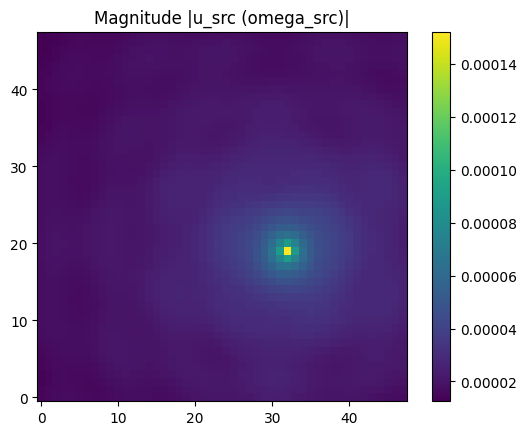

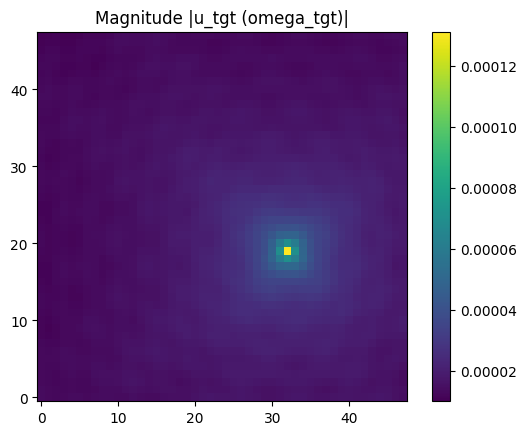

In [5]:
import matplotlib.pyplot as plt

def plot_complex_field(u, title: str):
    """u: (2, Ny, Nx) tensor with [Re, Im]."""
    u_np = u.numpy()
    u_complex = u_np[0] + 1j * u_np[1]
    mag = np.abs(u_complex)
    fig, ax = plt.subplots()
    im = ax.imshow(mag, origin="lower")
    fig.colorbar(im, ax=ax)
    ax.set_title(title)
    plt.show()

plot_complex_field(u_src, "Magnitude |u_src (omega_src)|")
plot_complex_field(u_tgt, "Magnitude |u_tgt (omega_tgt)|")


## 4. Model: SimpleFNO for frequency transfer

We use `SimpleFNO`:

- Input shape: `(B, C_in, Ny, Nx)`
- Output shape: `(B, 2, Ny, Nx)` (Re/Im of target field)

Here `C_in = 2` because we only feed the source field `[Re, Im]`.
We can later extend this to include extra channels (e.g., k-map or medium).


In [6]:
import torch

# Infer channels from one sample
sample_x, sample_y = dataset[0]
in_channels = sample_x.shape[0]   # should be 2
out_channels = sample_y.shape[0]  # should be 2

print("in_channels =", in_channels, "out_channels =", out_channels)

# Construct a small FNO-style model
model = SimpleFNO(
    in_ch=in_channels,
    width=48,              # model width (can tune)
    modes=(12, 12),        # spectral modes in each dimension
    layers=4,              # number of FNO layers
)
model


in_channels = 2 out_channels = 2


SimpleFNO(
  (proj_in): Conv2d(2, 48, kernel_size=(1, 1), stride=(1, 1))
  (spectral): ModuleList(
    (0-3): 4 x SpectralConv2d()
  )
  (w): ModuleList(
    (0-3): 4 x Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  )
  (act): GELU(approximate='none')
  (proj_out): Conv2d(48, 2, kernel_size=(1, 1), stride=(1, 1))
)

## 5. Training loop with `train_model`

We use the generic helper:

```python
train_model(model, dataset, epochs, batch_size, lr, val_split)


In [7]:
### 🎯 Cell 12 — Code: train the model

# Training hyperparameters
epochs = 50
batch_size = 8
learning_rate = 1e-3

model, history = train_model(
    model=model,
    dataset=dataset,
    epochs=epochs,
    batch_size=batch_size,
    lr=learning_rate,
    val_split=0.2,
    device=None,   # auto: "cuda" if available, else "cpu"
    verbose=True,
)


[001/50] train=1.0905e+02  val=5.2851e+00
[002/50] train=2.4153e+00  val=3.1512e-01
[003/50] train=1.1827e-01  val=3.5854e-02
[004/50] train=2.5341e-02  val=1.7412e-02
[005/50] train=1.3633e-02  val=1.0884e-02
[006/50] train=9.4445e-03  val=8.0587e-03
[007/50] train=7.1471e-03  val=6.2591e-03
[008/50] train=5.6142e-03  val=4.9700e-03
[009/50] train=4.4840e-03  val=3.9906e-03
[010/50] train=3.6111e-03  val=3.2233e-03
[011/50] train=2.9228e-03  val=2.6151e-03
[012/50] train=2.3762e-03  val=2.1316e-03
[013/50] train=1.9418e-03  val=1.7476e-03
[014/50] train=1.5973e-03  val=1.4436e-03
[015/50] train=1.3248e-03  val=1.2035e-03
[016/50] train=1.1099e-03  val=1.0143e-03
[017/50] train=9.4057e-04  val=8.6532e-04
[018/50] train=8.0723e-04  val=7.4788e-04
[019/50] train=7.0196e-04  val=6.5495e-04
[020/50] train=6.1842e-04  val=5.8094e-04
[021/50] train=5.5163e-04  val=5.2146e-04
[022/50] train=4.9768e-04  val=4.7309e-04
[023/50] train=4.5354e-04  val=4.3324e-04
[024/50] train=4.1694e-04  val=3.9

## 6. Inspect training history

We can visualize the train/val MSE curves to check for under/overfitting.


In [ ]:
train_loss = history["train"]
val_loss = history["val"]

plt.figure()
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training history (SimpleFNO, freq transfer with PML)")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()


## 7. Quantitative evaluation: `eval_relative_metrics`

We compute:

- mean / median / 90th percentile relative L2 error per sample,
- magnitude RMSE,
- phase RMSE (phase difference wrapped to \\([-π, π]\\)).


In [ ]:
metrics = eval_relative_metrics(
    model=model,
    dataset=dataset,
    batch_size=16,
)

metrics


## 8. Save trained model

We store the model weights in the standard `RESULTS_DIR` for later reuse.


In [ ]:
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

model_path = RESULTS_DIR / "simplefno_freq_transfer_pml.pt"
torch.save(model.state_dict(), model_path)

print("Saved model weights to:", model_path)
